# **IMPORTANTE**: Seguir os passos abaixo para obter acesso aos arquivos CSV fornecidos pelo cliente no Drive da Turma



1.   Logar na sua conta no Google Drive
2.   No canto esquerdo, clicar em "Shared with me" (ou "Drives Compartilhados") <br> 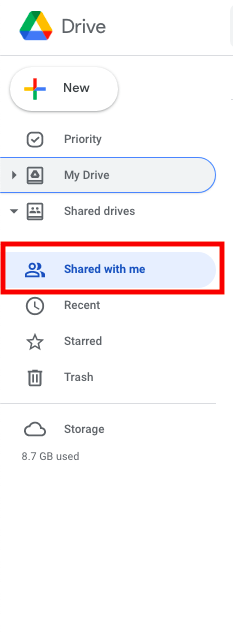

3.   Procurar e clicar com o botão *esquerdo* do mouse na pasta "Turma 2022.1 - Preditivo - Rappi" <br> 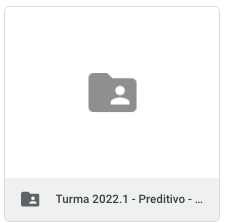

4.  Clicar com o botão *direito* do mouse na pasta "Bases" e selecionar a opção "Add shortcut to Drive" (ou "Adicionar atalho para o Drive") <br>
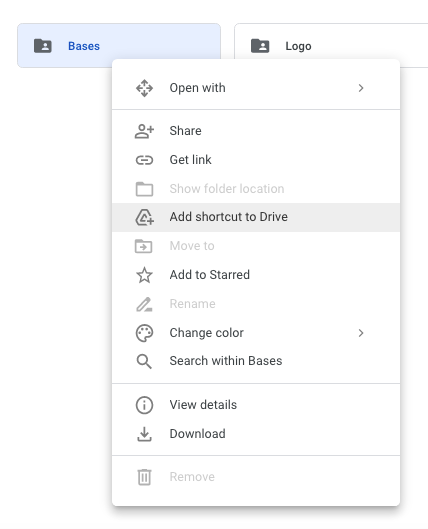

5. Agora a pasta compartilhada está acessível a partir do seu Drive! Clone este Notebook e inicie o "runtime" clicando no botão "Connect" no canto superior esquerdo. 

6. Uma vez que o "runtime" esteja rodando, clique no ícone de "pasta" à esquerda e no botão de "montar drive". Autorize a operação. <br> 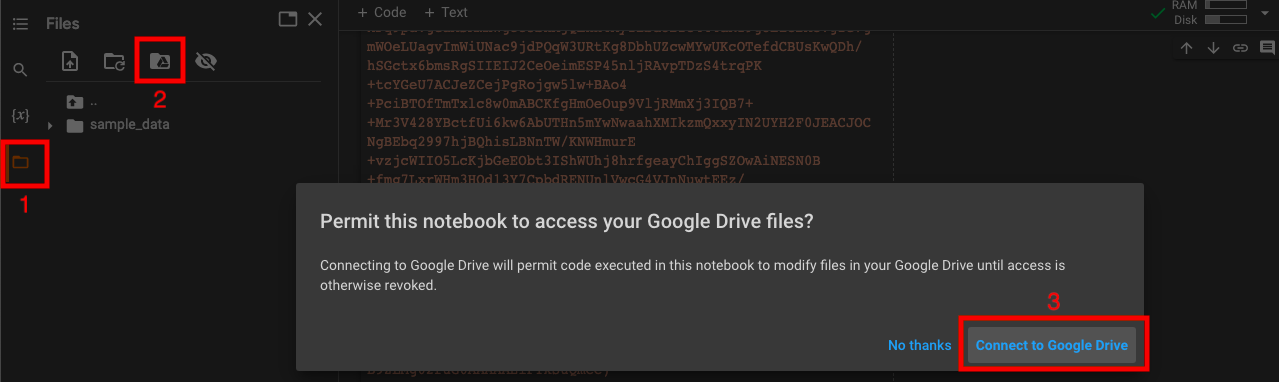

7.  Rode os próximos passos para importar os arquivos.

In [ ]:
# lista de arquivos, para referência
# OK df_attendance = pd.read_csv('/content/drive/MyDrive/Bases/attendance rate.csv')
# OK df_infos = pd.read_csv('/content/drive/MyDrive/Bases/infos gerais.csv') 
# OK df_defects = pd.read_csv('/content/drive/MyDrive/Bases/comp defects.csv')
# OK df_churn = pd.read_csv('/content/drive/MyDrive/Bases/criacao contas churn-002.csv')
# OK df_earnings = pd.read_csv('/content/drive/MyDrive/Bases/earnings.csv')
# OK df_incidents = pd.read_csv('/content/drive/MyDrive/Bases/Incidentes_Regras RT.csv')
# OK df_km = pd.read_csv('/content/drive/MyDrive/Bases/2022-08-10 10_40am.csv')
# OK df_orders = pd.read_csv('/content/drive/MyDrive/Bases/Ordens Done e Cancel.csv')
# OK df_resolution = pd.read_csv('/content/drive/MyDrive/Bases/tempo resolucao e modal 2.csv')
# OK df_returns = pd.read_csv('/content/drive/MyDrive/Bases/Product return.csv')
# OK df_supply = pd.read_csv('/content/drive/MyDrive/Bases/supply.csv')


# Concatenar, otimizar e selecionar colunas das bases de dados

## Importar bibliotecas necessárias

In [ ]:
import pandas as pd
import datetime
import gc

## Usar a tabela "Infos Gerais" dos Entregadores como ponto de partida para uma Tabela Consolidada

### Importar, otimizar 



In [ ]:
df_infos = pd.read_csv('/content/drive/MyDrive/Bases/infos gerais.csv', 
                       usecols=['ID', 'IS_ACTIVE', 'TRANSPORTE', 'AUTO_ACEITE', 'COUNT_ORDERS_LAST_30D', 'COUNT_ORDERS_CANCELED_LAST_30D', 'PRIMEIRO_PEDIDO', 'ULTIMO_PEDIDO'],
                       dtype={'ID': 'int32', 'TRANSPORTE': 'category', 'COUNT_ORDERS_CANCELED_LAST_30D': 'int16', 'COUNT_ORDERS_LAST_30D': 'int16'})

### Ajustes na tabela consolidada

In [ ]:
# Converter strings de data para datetime
df_infos['PRIMEIRO_PEDIDO'] = pd.to_datetime(df_infos['PRIMEIRO_PEDIDO'])
df_infos['ULTIMO_PEDIDO'] = pd.to_datetime(df_infos['ULTIMO_PEDIDO'])

# Criar coluna Booleana para checar se último pedido foi há mais de 21 dias (entregador em "churn" atualmente)
df_infos['>21D_SINCE_LAST_ORDER'] = df_infos['ULTIMO_PEDIDO'] < '2022-07-11'

# Padronizar os nomes das colunas
df_infos.rename(columns={'TRANSPORTE': 'TRANSPORT', 
                         'AUTO_ACEITE': 'AUTO_ACCEPT', 
                         'COUNT_ORDERS_LAST_30D': 'ORDERS_LAST_30D_COUNT',
                         'COUNT_ORDERS_CANCELED_LAST_30D': 'ORDERS_CANCELED_LAST_30D_COUNT',
                         'PRIMEIRO_PEDIDO': 'FIRST_ORDER_DATE',
                         'ULTIMO_PEDIDO': 'LAST_ORDER_DATE'}, 
                inplace=True)

## Left Join com "Criacao Contas Churn" (Entregadores que deram "Churn")

### Importar, otimizar

In [ ]:
df_churn = pd.read_csv('/content/drive/MyDrive/Bases/criacao contas churn-002.csv', 
                       usecols=['ID', 'SK.CREATED_AT::DATE'])

In [ ]:
# Remover IDs duplicados
df_churn = df_churn.drop_duplicates(subset=['ID'])

### "Infos Gerais" LEFT JOIN "Criacao Contas Churn" 

In [ ]:
df_infos = pd.merge(df_infos, df_churn, on='ID', how='left')

### Ajustes na Tabela Consolidada

In [ ]:
# Converter data de criação da conta para datetime
df_infos['SK.CREATED_AT::DATE'] = pd.to_datetime(df_infos['SK.CREATED_AT::DATE'])

# Criar coluna Booleana para checar se o entregador está na tabela de churn
df_infos['IS_IN_CHURN_TABLE'] = df_infos['SK.CREATED_AT::DATE'].notnull()

# Renomear coluna de data de criação da conta para que fique mais claro
df_infos.rename(columns={'SK.CREATED_AT::DATE': 'SIGNUP_DATE'}, inplace=True)

# PONTO RELEVANTE: 15616 entregadores fizeram o pedido há mais de 21 dias e não estão na tabela de Churn
# df_infos.loc[(df_infos['>21D_SINCE_LAST_ORDER']) & (df_infos['IS_IN_CHURN_TABLE'] == False)].shape



### Liberar memória

In [ ]:
del df_churn
gc.collect()

22

## Inner Join com "Earnings" (Receitas dos Entregadores)

### Importar, Otimizar

In [ ]:
df_earnings = pd.read_csv('/content/drive/MyDrive/Bases/earnings.csv', 
                          usecols = ['STOREKEEPER_ID', 'EARNINGS', 'TIPS'], 
                          dtype={'EARNINGS': 'float32' , 'TIPS': 'float32'})

### Somar os "Earnings" e "Tips" de cada entregador


In [ ]:
total_earnings_by_id = df_earnings.groupby(['STOREKEEPER_ID'])['EARNINGS'].sum()
total_tips_by_id = df_earnings.groupby(['STOREKEEPER_ID'])['TIPS'].sum()

### "Infos Gerais" INNER JOIN "earnings"


*   Essa operação irá descartar todos os entregadores sem 'earnings' ou 'tips'


In [ ]:
df_infos = pd.merge(df_infos, total_earnings_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='inner')
df_infos = pd.merge(df_infos, total_tips_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='inner')

df_infos.shape

(166325, 13)

### Liberar memoria

In [ ]:
del df_earnings
del total_earnings_by_id
del total_tips_by_id
gc.collect()

22

## Left join com "Incidentes Regras RT" (Medidas Disciplinares contra Entregadores)

### Importar, otimizar

In [ ]:
df_incidents = pd.read_csv('/content/drive/MyDrive/Bases/Incidentes_Regras RT.csv',
                           usecols=['STOREKEEPER_ID', 'PUNISHMENT_MINUTES'])
df_incidents.head()

,STOREKEEPER_ID,PUNISHMENT_MINUTES
0,1089595,15
1,1379883,21600000
2,1445261,300
3,246044,0
4,1392515,0


### Somar os "Punishment Minutes" de cada entregador

---



In [ ]:
total_punishment_minutes_by_id = df_incidents.groupby(['STOREKEEPER_ID'])['PUNISHMENT_MINUTES'].sum()

### "Infos Gerais" LEFT JOIN "earnings"

In [ ]:
df_infos = pd.merge(df_infos, total_punishment_minutes_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='left')

### Ajustes na tabela consolidada

In [ ]:
# Assumir que todos os entregadores que não estão na lista de incidentes não tiveram punicões
df_infos['PUNISHMENT_MINUTES'] = df_infos['PUNISHMENT_MINUTES'].fillna(0)
# Otimizar a coluna de minutos para que seja um inteiro
df_infos['PUNISHMENT_MINUTES'] = df_infos['PUNISHMENT_MINUTES'].astype('int64')

### Liberar memória

In [ ]:
del df_incidents
del total_punishment_minutes_by_id
gc.collect()

66

## Inner join com total de "Ordens Realizadas e Canceladas"

### Importar, otimizar

In [ ]:
df_orders = pd.read_csv('/content/drive/MyDrive/Bases/Ordens Done e Cancel.csv',
                        usecols=['STOREKEEPER_ID', 'ORDERS_DONE', 'ORDERS_CANCEL'],
                        dtype={'ORDERS_DONE': 'int16', 'ORDERS_CANCEL': 'int16'})

### "Infos Gerais" INNER JOIN "Ordens Done e Cancel"

In [ ]:
df_infos = pd.merge(df_infos, df_orders, left_on='ID', right_on='STOREKEEPER_ID', how='inner')
# Remover coluna repetida com ID do entregador
df_infos = df_infos.drop(columns='STOREKEEPER_ID')

### Liberar memória

In [ ]:
del df_orders
gc.collect()

66

## Inner join com média de "KM rodados por pedido"

### Importar, otimizar

In [ ]:
df_km = pd.read_csv('/content/drive/MyDrive/Bases/2022-08-10 10_40am.csv',
                    usecols=['STOREKEEPER_ID', 'DISTANCE_TO_USER'],
                    dtype={'DISTANCE_TO_USER': 'float32'})

### Obter a mediana de "KM rodados por pedido" para cada entregador

In [ ]:
avg_km_by_id = df_km.groupby(['STOREKEEPER_ID'])['DISTANCE_TO_USER'].median()

### "Infos Gerais" INNER JOIN "Média de KM rodados por pedido"

In [ ]:
df_infos = pd.merge(df_infos, avg_km_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='inner')

### Ajustes na tabela consolidada

In [ ]:
df_infos.rename(columns={'DISTANCE_TO_USER': 'AVG_DISTANCE_TO_USER'}, inplace=True)

### Liberar memória

In [ ]:
del df_km
del avg_km_by_id
gc.collect()

44

## Left join com "Quantidade de pedidos ao suporte da Rappi" por entregador

### Importar, otimizar

In [ ]:
df_resolution = pd.read_csv('/content/drive/MyDrive/Bases/tempo resolucao e modal 2.csv',
                            usecols=['STOREKEEPER_ID', 'RESPONSE_TIME'])

### Contar quantos pedidos foram abertos por cada entregador

In [ ]:
resolution_count_by_id = df_resolution.groupby('STOREKEEPER_ID')['RESPONSE_TIME'].count()

### "Infos Gerais" INNER JOIN "Pedidos Abertos Por Entregador"

In [ ]:
df_infos = pd.merge(df_infos, resolution_count_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='left')

### Ajustes na tabela consolidada

In [ ]:
# Assumir que os entregadores que não estão na tabela de pedidos de suporte nunca abriram um ticket de suporte
df_infos['RESPONSE_TIME'] = df_infos['RESPONSE_TIME'].fillna(0)

# Renomear coluna
df_infos.rename(columns={'RESPONSE_TIME': 'SUPPORT_TICKET_COUNT'}, inplace=True)

# Otimizar dados
df_infos['SUPPORT_TICKET_COUNT'] = df_infos['SUPPORT_TICKET_COUNT'].astype('int16')

### Liberar memória

In [ ]:
del df_resolution
del resolution_count_by_id
gc.collect()

110

## Left join com total de "Devoluções Pendentes" por entregador

### Importar, otimizar

In [ ]:
df_returns = pd.read_csv('/content/drive/MyDrive/Bases/Product return.csv',
                         usecols=['ID_ENTREGADOR', 'PRODUCT_RETURNS'])

### Obter a soma de todas as devoluções pendentes, por entregador

In [ ]:
total_returns_by_id = df_returns.groupby(['ID_ENTREGADOR'])['PRODUCT_RETURNS'].sum()

### "Infos Gerais" LEFT JOIN "Returns"

In [ ]:
df_infos = pd.merge(df_infos, total_returns_by_id, left_on='ID', right_on='ID_ENTREGADOR', how='left')

### Ajustes na tabela consolidada

In [ ]:
# Assumir que todos os entregadores que não estão na lista de devoluções pendentes não têm produtos a devolver
df_infos['PRODUCT_RETURNS'] = df_infos['PRODUCT_RETURNS'].fillna(0)

# Otimizar dados
df_infos['PRODUCT_RETURNS'] = df_infos['PRODUCT_RETURNS'].astype('float16')

### Liberar memória

In [ ]:
del df_returns
del total_returns_by_id
gc.collect()

110

## Left join com média de "Tempo Conectado por Dia" do entregador

### Importar, otimizar

In [ ]:
df_supply = pd.read_csv('/content/drive/MyDrive/Bases/supply.csv',
                        usecols=['STOREKEEPER_ID', 'SUPPLY_HOURS'],
                        dtype={'SUPPLY_HOURS': 'float16'})

### Obter a mediana de horas trabalhadas por entregador

In [ ]:
average_hours_by_id = df_supply.groupby(['STOREKEEPER_ID'])['SUPPLY_HOURS'].median()

### "Infos Gerais" LEFT JOIN "Supply"

In [ ]:
df_infos = pd.merge(df_infos, average_hours_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='left')

### Ajustes na tabela consolidada

In [ ]:
# Renomear coluna com média das horas trabalhadas
df_infos.rename(columns={'SUPPLY_HOURS': 'AVG_SUPPLY_HOURS'}, inplace=True)

### Liberar memória

In [ ]:
del df_supply
del average_hours_by_id
gc.collect()

110

## Inner join com "Taxa de Aceitação dos Pedidos" pelos entregadores


### Importar, otimizar

In [ ]:
df_attendance = pd.read_csv('/content/drive/MyDrive/Bases/attendance rate.csv',
                            usecols=['STOREKEEPER_ID', 'ACCEPTANCE_RATE'],
                            dtype={'ACCEPTANCE_RATE':'float16'})

### "Infos Gerais" INNER JOIN "Aceptance Rate"

In [ ]:
df_infos = pd.merge(df_infos, df_attendance, left_on='ID', right_on='STOREKEEPER_ID', how='inner')

# Remover dados nulos vindos do inner join
df_infos = df_infos.dropna(subset=['ACCEPTANCE_RATE'])

# Remover coluna repetida com ID do entregador
df_infos = df_infos.drop(columns='STOREKEEPER_ID')


### Liberar memória

In [ ]:
del df_attendance
gc.collect()

66

## Left join com "Pedidos com Problema"

### Importar, otimizar

In [ ]:
df_defects = pd.read_csv('/content/drive/MyDrive/Bases/comp defects.csv',
                         usecols=['STOREKEEPER_ID', 'LEVEL_NAME', 'ORDERS'],
                         dtype={'LEVEL_NAME': 'category'})


### Contar o número de pedidos com problema

In [ ]:
defects_count_by_id = df_defects.groupby(['STOREKEEPER_ID'])['ORDERS'].count()



### Selecionar apenas os level_names dos entregadores

In [ ]:
# Remover duplicados
df_defects = df_defects[['STOREKEEPER_ID', 'LEVEL_NAME']].drop_duplicates(subset='STOREKEEPER_ID')

### "Infos Gerais" LEFT JOIN "defects"

In [ ]:
df_infos = pd.merge(df_infos, defects_count_by_id, left_on='ID', right_on='STOREKEEPER_ID', how='left')

In [ ]:
df_infos = pd.merge(df_infos, df_defects, left_on='ID', right_on='STOREKEEPER_ID', how='left')


In [ ]:
# Remover coluna repetida com ID do entregador
df_infos = df_infos.drop(columns='STOREKEEPER_ID')

### Ajustes na tabela consolidada

In [ ]:
# Otimizar
df_infos['ORDERS'] = df_infos['ORDERS'].astype('int32')

# Renomear coluna com contagem de ordens com algum problema
df_infos.rename(columns={'ORDERS': 'DEFECTS_COUNT'}, inplace=True)

### Liberar memória

In [ ]:
del df_defects
del defects_count_by_id
gc.collect()

154

## Ajustes finais na tabela consolidada

### Criar uma coluna booleana para rotular um entregador como "churn" (_"target"_ do modelo preditivo)

Assumimos que um "Churn" é um entregador que se encontra em **uma ou mais** das condições abaixo:
* Seu estado na tabela 'Infos Gerais' está inativo ('IS_ACTIVE' é falso); OU
* Seu ID está na tabela de entregadores que deram churn ('IS_IN_CHURN_TABLE' é verdadeiro); OU
* A data de sua última entrega na tabela 'Infos Gerais' foi há mais de 21 dias ('>21D_SINCE_LAST_ORDER' é verdadeiro).

In [ ]:
df_infos['IS_CHURN'] = df_infos['IS_ACTIVE'] == False | df_infos['IS_IN_CHURN_TABLE'] | df_infos['>21D_SINCE_LAST_ORDER']


### Remover colunas que não são úteis para definição das __"features"__ e reordenar as demais



*   A coluna "SIGNUP_DATE" não é útil pois está apenas na tabela das contas que deram "churn". Por isso, não temos como comparar essas datas com as das contas que _não_ deram "churn".
*   A coluna "AVG_SUPPLY_HOURS" não é útil pois poucos entregadores estão na tabela de "supply" (6560 dos 163293 existentes após os 'inner joins'). Por existirem muitos campos nulos, não é possível construir uma "feature" adequada a partir dessa coluna.
*   As colunas 'IS_ACTIVE', 'IS_IN_CHURN_TABLE' e '>21D_SINCE_LAST_ORDER' foram usadas exclusivamente para rotular um entregador como 'churn' e não tem relação com a definição de features.


In [ ]:
print(df_infos.columns.values)

# Ordenar colunas
df_infos = df_infos[['ID', 'IS_CHURN',
                    'LEVEL_NAME', 'TRANSPORT', 
                    'AUTO_ACCEPT', 'ACCEPTANCE_RATE', 
                    'ORDERS_DONE','ORDERS_LAST_30D_COUNT', 
                    'ORDERS_CANCEL', 'ORDERS_CANCELED_LAST_30D_COUNT', 
                    'FIRST_ORDER_DATE', 'LAST_ORDER_DATE', 
                    'EARNINGS', 'TIPS', 
                    'PUNISHMENT_MINUTES', 'PRODUCT_RETURNS', 
                    'SUPPORT_TICKET_COUNT', 'DEFECTS_COUNT', 
                    'AVG_DISTANCE_TO_USER', 
                    ]]

['ID' 'IS_ACTIVE' 'TRANSPORT' 'AUTO_ACCEPT' 'ORDERS_LAST_30D_COUNT'
 'ORDERS_CANCELED_LAST_30D_COUNT' 'FIRST_ORDER_DATE' 'LAST_ORDER_DATE'
 '>21D_SINCE_LAST_ORDER' 'SIGNUP_DATE' 'IS_IN_CHURN_TABLE' 'EARNINGS'
 'TIPS' 'PUNISHMENT_MINUTES' 'ORDERS_DONE' 'ORDERS_CANCEL'
 'AVG_DISTANCE_TO_USER' 'SUPPORT_TICKET_COUNT' 'PRODUCT_RETURNS'
 'AVG_SUPPLY_HOURS' 'ACCEPTANCE_RATE' 'DEFECTS_COUNT' 'LEVEL_NAME'
 'IS_CHURN']


## Aplicar encoding para dados categóricos

In [ ]:
# TRANSPORT é categórico nominal, aplicar One-Hot Encoding
df_infos = pd.get_dummies(df_infos, columns=['TRANSPORT'])

In [ ]:
# LEVEL_NAME é categórico ordinal, aplicar Label Encoding
df_infos.LEVEL_NAME = df_infos.LEVEL_NAME.replace({'danger':0, 'rookie':1, 'bronze':2, 'silver': 3, 'diamond': 4})

In [ ]:
# Converter as datas para ordinais
df_infos['FIRST_ORDER_DATE'] = df_infos['FIRST_ORDER_DATE'].apply(lambda x: x.toordinal())
df_infos['LAST_ORDER_DATE'] = df_infos['LAST_ORDER_DATE'].apply(lambda x: x.toordinal())



In [ ]:
# df_infos.to_csv('/content/features.csv')

In [ ]:
df_infos.loc[(df_infos['IS_CHURN'] == False) & (df_infos['SUPPORT_TICKET_COUNT'] == 0)]

,ID,IS_CHURN,LEVEL_NAME,AUTO_ACCEPT,ACCEPTANCE_RATE,ORDERS_DONE,ORDERS_LAST_30D_COUNT,ORDERS_CANCEL,ORDERS_CANCELED_LAST_30D_COUNT,FIRST_ORDER_DATE,...,PRODUCT_RETURNS,SUPPORT_TICKET_COUNT,DEFECTS_COUNT,AVG_DISTANCE_TO_USER,TRANSPORT_bicycle,TRANSPORT_car,TRANSPORT_motorbike,TRANSPORT_neither,TRANSPORT_cargo_van,TRANSPORT_motorbike_trailer
0,1552668,False,1,True,1.000000,0,4,1,0,738354,...,0.00000,0,2,3.765437,0,0,1,0,0,0
1,1552649,False,3,True,0.777832,4,122,1,2,738353,...,0.00000,0,8,4.014581,0,0,1,0,0,0
2,1552604,False,2,True,1.000000,3,57,0,1,738353,...,0.00000,0,9,1.517087,1,0,0,0,0,0
3,1552588,False,4,True,0.000000,1,59,0,2,738354,...,0.00000,0,7,2.256725,0,1,0,0,0,0
4,1552553,False,1,True,0.888672,3,9,0,0,738353,...,0.00000,0,5,2.736529,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163272,33346,False,2,True,0.784668,727,7,42,0,738003,...,-36.65625,0,178,3.307353,0,0,1,0,0,0
163279,33266,False,2,False,0.192017,398,20,20,2,738264,...,0.00000,0,34,2.994990,0,0,1,0,0,0
163280,33263,False,4,True,0.092468,3337,292,25,1,738003,...,0.00000,0,343,2.307577,0,0,1,0,0,0
163285,33203,False,4,True,0.491699,338,77,12,1,738191,...,0.00000,0,98,1.830830,1,0,0,0,0,0
